In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [9]:
# Define the objective function that simulates the efficiency of a chemical process as a function of pH and temperature
def objective_function(pH, temperature):
    """
    Function with a global maximum in the range:
    pH ∈ [3, 11], temperature ∈ [0, 20].
    The global maximum is at pH = 11, temperature = 2.
    """
    return 80 * np.exp(-((pH-11)**2 + (temperature-2)**2) / 10) + 10 * np.sin(0.5 * pH) + 5 * np.sin(0.5 * temperature)

# define ranges for pH and temperature for plotting
pH_range = np.linspace(3, 11, 100)
temperature_range = np.linspace(0, 20, 100)

# Create meshgrid for pH and temperature
pH_mesh, temperature_mesh = np.meshgrid(pH_range, temperature_range)
efficiency = objective_function(pH_mesh, temperature_mesh)

# Create Plotly surface plot
fig = go.Figure(data=[go.Surface(
    z=efficiency,
    x=pH_mesh,
    y=temperature_mesh,
    colorscale='Viridis'
)])


# Update layout
fig.update_layout(
    title="Efficiency of a chemical process",
    scene=dict(
        xaxis_title="pH",
        yaxis_title="Temperature (°C)",
        zaxis_title="Efficiency (%)"
    ),
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=0)
)
    
# Show plot
fig.show()

# Case 1 - One-at-a-time

Sample a subset of combinations, with a total number of combinations equal to 25.

In [10]:
from itertools import product

In [11]:
# Suppose to have a target function that simulates the efficiency of a chemical process as a function of pH and temperature
# but with added noise
def target_function(pH, temperature):
    result = objective_function(pH, temperature) + np.random.normal(0, 2)  # Add noise
    return np.clip(result, 0, 100)  # Clip to the range [0, 100]

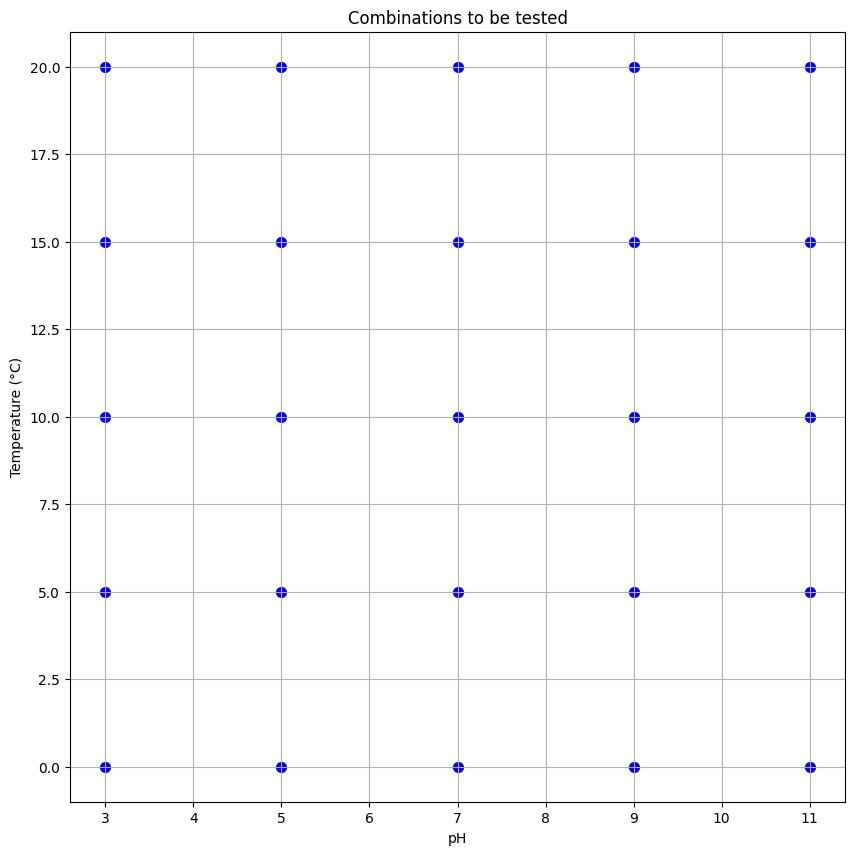

In [12]:
# Create a 2d plot with the combinations that will be used

pH = np.linspace(3, 11, 5)
temperature = np.linspace(0, 20, 5)

combinations = list(product(pH, temperature))

# plot the points that will be tested in 2d
fig = plt.figure(figsize=(10, 10))

plt.grid()

for pH_value, temp_value in combinations:
    plt.scatter(pH_value, temp_value, c='b', s=50)


plt.xlabel('pH')
plt.ylabel('Temperature (°C)')
plt.title('Combinations to be tested')

plt.show()

In [13]:
# Simulate the sampling process by evaluating the target function at each combination of pH and temperature
# and storing the results in a pandas DataFrame
# The process is repeated for a number of iterations

n_iterations = 3
df = pd.DataFrame()

for i in range(n_iterations):
    df_iteration = pd.DataFrame(combinations, columns=['pH', 'temperature'])
    
    df_iteration['efficiency'] = df_iteration.apply(lambda x: target_function(x['pH'], x['temperature']), axis=1)
    df_iteration['iteration'] = i + 1
    
    df = pd.concat([df, df_iteration], axis=0)

df.reset_index(drop=True, inplace=True)

In [14]:
df

,pH,temperature,efficiency,iteration
0,3.0,0.0,12.399705,1
1,3.0,5.0,14.715793,1
2,3.0,10.0,0.000000,1
3,3.0,15.0,11.845852,1
4,3.0,20.0,10.298561,1
...,...,...,...,...
70,11.0,0.0,50.586512,3
71,11.0,5.0,25.793294,3
72,11.0,10.0,0.000000,3
73,11.0,15.0,0.839149,3


In [15]:
# Create a 3D plot with the points that have been tested
fig = go.Figure()

# Iterate through each iteration and add a separate trace
for iteration in df['iteration'].unique():
    df_iter = df[df['iteration'] == iteration]
    fig.add_trace(go.Scatter3d(
        x=df_iter['pH'],
        y=df_iter['temperature'],
        z=df_iter['efficiency'],
        mode='markers',
        name=f'Iteration {iteration}',
        marker=dict(
            size=5,
            opacity=0.8
        )
    ))
    
    
# plot the real function
fig.add_trace(go.Surface(
    z=efficiency,
    x=pH_mesh,
    y=temperature_mesh,
    colorscale='Viridis',
    opacity=0.5,
    showscale=False
))

fig.update_layout(
    title="3D Plot of Tested Combinations",
    scene=dict(
        xaxis_title="pH",
        yaxis_title="Temperature (°C)",
        zaxis_title="Efficiency (%)"
    ),
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=0),
    showlegend=True
)

fig.show()

With the sampling results, we are going to train a fully quadratic linear regression and find the pair (pH, Temp)
that maximizes the regression.

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2)

X = df[['pH', 'temperature']]
y = df['efficiency']

X_poly = poly.fit_transform(X)


reg = LinearRegression().fit(X_poly, y)

In [17]:
# get the pH and temperature pair that maximizes the efficiency
def target(x, y):
    return reg.predict(poly.fit_transform([[x, y]]))

efficiency = 0
best_pH = 3
best_temp = 0

for pH_value in pH:
    for temp_value in temperature:
        value = target(pH_value, temp_value)
        if value > efficiency:
            efficiency = value
            best_pH = pH_value
            best_temp = temp_value
            
print(f"Best pH: {best_pH}, Best Temperature: {best_temp}, Efficiency: {efficiency}")

Best pH: 11.0, Best Temperature: 0.0, Efficiency: [39.38061863]


# Case 2 - DoE

In [18]:
# Define the points that will be sampled, following the DoE approach

middle_pH = (pH[0] + pH[-1]) / 2
middle_temp = (temperature[0] + temperature[-1]) / 2

star_points = [
    (middle_pH, temperature[0]),
    (middle_pH, temperature[-1]),
    (pH[0], middle_temp),
    (pH[-1], middle_temp),
]

temp_step = (middle_temp - temperature[0]) / np.sqrt(2) * 1

pH_step = (middle_pH - pH[0]) / np.sqrt(2) * 1

square_points = [
    ((middle_pH - pH_step).round(2), (middle_temp - temp_step).round(2)),
    ((middle_pH - pH_step).round(2), (middle_temp + temp_step).round(2)),
    ((middle_pH + pH_step).round(2), (middle_temp - temp_step).round(2)),
    ((middle_pH + pH_step).round(2), (middle_temp + temp_step).round(2)),
]

In [19]:
evaluation_points = square_points + star_points

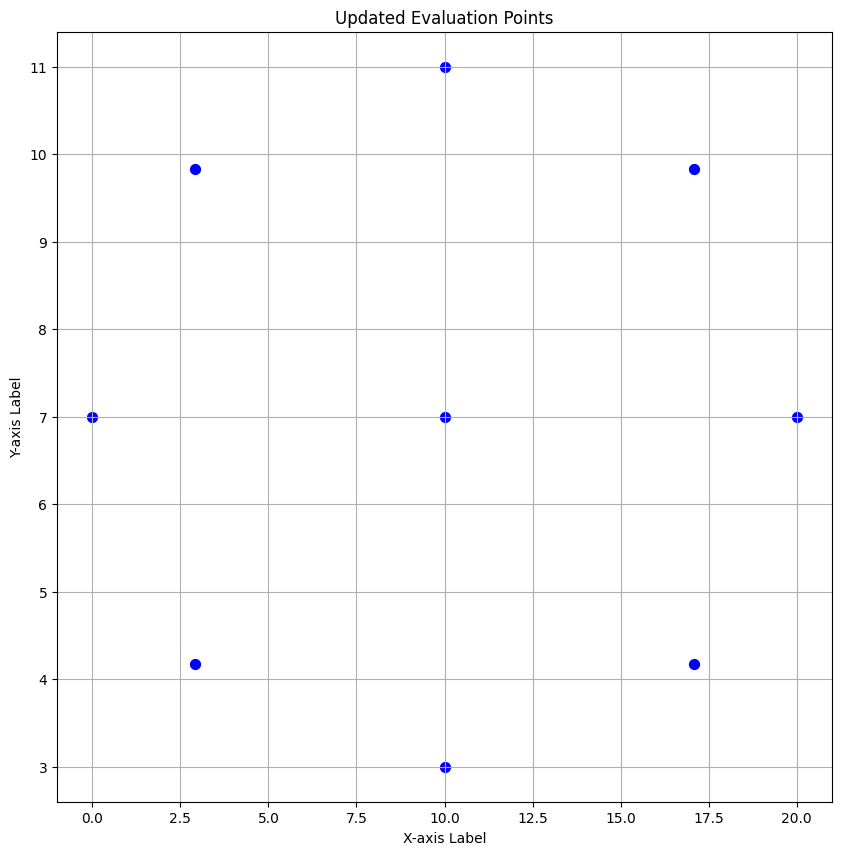

In [20]:
# plot the evaluation points
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.grid()
plt.title('Evaluation Points')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')

for pH_value, temp_value in evaluation_points + [(middle_pH, middle_temp)]:
    plt.scatter(temp_value, pH_value, c='b', s=50)

plt.title('Updated Evaluation Points')
plt.show()
    

In [21]:
df = pd.DataFrame()

In [22]:
# Perform the sampling process for the new evaluation points, by sampling the 
# middle points x6 and the other points x1
for _ in range(0, 6):
    efficiency = target_function(middle_pH, middle_temp)
    new_row = pd.DataFrame([[middle_pH, middle_temp, efficiency]], columns=['pH', 'temperature', 'efficiency'])
    df = pd.concat([df, new_row], axis=0)

for pH_value, temp_value in evaluation_points:
    efficiency = target_function(pH_value, temp_value)
    new_row = pd.DataFrame([[pH_value, temp_value, efficiency]], columns=['pH', 'temperature', 'efficiency'])
    df = pd.concat([df, new_row], axis=0)
df.reset_index(drop=True, inplace=True)

In [23]:
df

,pH,temperature,efficiency
0,7.00,10.00,0.000000
1,7.00,10.00,0.000000
2,7.00,10.00,0.000000
3,7.00,10.00,0.000000
4,7.00,10.00,0.000000
5,7.00,10.00,0.000000
6,4.17,2.93,16.109670
7,4.17,17.07,13.078809
8,9.83,2.93,57.162420
9,9.83,17.07,0.000000


With the sampling results, we are going to train a fully quadratic linear regression and find the pair (pH, Temp)
that maximizes the regression.

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2)

X = df[['pH', 'temperature']]
y = df['efficiency']

X_poly = pd.DataFrame(poly.fit_transform(X))
reg = LinearRegression().fit(X_poly, y)

In [25]:
# get the pH and temperature pair that maximizes the efficiency
def target(x, y):
    return reg.predict(poly.fit_transform([[x, y]]))

efficiency = 0
best_pH = 3
best_temp = 0

for pair in evaluation_points + [(middle_pH, middle_temp)]:
    pH_value, temp_value = pair
    value = target(pH_value, temp_value)
    if value > efficiency:
        efficiency = value
        best_pH = pH_value
        best_temp = temp_value

print(f"Best pH: {best_pH}, Best Temperature: {best_temp}, Efficiency: {efficiency}")

Best pH: 9.83, Best Temperature: 2.93, Efficiency: [37.32065581]


# Case 3 - Bayesian Optimization

Run the file named bayesian_optimization_without_local_max.py